In [56]:
import pandas as pd
import numpy as np
import utm
from datetime import datetime

def load_flujo_files(filename):
    datos = pd.read_csv(filename,sep=";")
    datos = datos.iloc[1000:3600] #first 3700 rows have data
    dates = datos["FECHA"]+" "+datos["HORA"]
    formated = []
    for date in dates:
        formated.append(datetime.strptime(date, '%d/%m/%y %H:%M:%S').strftime('%Y/%m/%d %H:%M:%S'))
   
    datos["DATETIME"] = formated
    datos = datos[["DATETIME","LATITUD","LONGITUD","ALTITUD","VELOCIDAD","CONSUMO_TOTAL","CPNSUMO_INSTANTANEO"]]
    datos.dropna(inplace=True)
    datos["LATITUD"] = pd.to_numeric(datos.LATITUD.str.slice(0, 6) + datos.LATITUD.str.slice(7, ))
    datos = datos[datos.LATITUD<0]
    datos["LONGITUD"] = pd.to_numeric(datos.LONGITUD.str.slice(0, 7) + datos.LONGITUD.str.slice(8, ))
    datos = datos[datos.LONGITUD<0]    
    datos = datos[(datos["ALTITUD"]<4000) & (datos["ALTITUD"]>1800)]
    return datos

In [57]:
import pandas as pd
import numpy as np
import utm

def process_data(latitude_array, longitude_array, height_array, date_array, utmzone, speed_array, consumo_array, consumo_instantaneo) :
    #1. UTM Coordinates
    min_distance = 0.01
    zone = utmzone.split(" ")
    zonenum = int(zone[0])
    zoneletter = zone[1]
    utms = utm.from_latlon(latitude_array,longitude_array,zonenum,zoneletter) #14Q for Mexico, 17S for Ecuador    
    utm_x = utms[0]
    utm_y = utms[1]
    last_utm_x = utm_x.shift(1) #last observation
    last_utm_y = utm_y.shift(1)
    last_height = height_array.shift(1)
    mean_height_diff = np.mean(np.abs(last_height-height_array))
    print("Average height difference:",mean_height_diff)
    distances = np.sqrt((utm_x-last_utm_x)**2 + (utm_y-last_utm_y)**2)+min_distance
    slopes = (height_array-last_height)/distances
    sumdistances = np.cumsum(distances)
    
    new_data = pd.DataFrame({"latitude":latitude_array, "longitude":longitude_array,\
                                "height":height_array, "distance":distances, "sum_distance":sumdistances,\
                                "slope":slopes, "date":date_array, "utm_x":utm_x, "utm_y":utm_y, \
                                "velocidad_gps":speed_array, "consumo_total":consumo_array, "consumo_inst":consumo_instantaneo
                                    })
    
    return new_data.dropna()

In [58]:
from datetime import datetime
import time

def add_speeds(datos):
    dates= datos["date"]
    datos["timestamp"] = 0
    formated = []
    for d in dates:
        formated.append(datetime.strptime(d, "%Y/%m/%d %H:%M:%S").timestamp())   
    datos["timestamp"] = formated
    last_timestamps = datos["timestamp"].shift(1)
    datos['ds'] =  datos["timestamp"]-last_timestamps
    datos['velocidad'] = datos['distance']/datos['ds']
    #datos["timestamp"] = datos["timestamp"]/1000000
    return datos.dropna()

In [59]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)-1):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters    
    return data

In [60]:
def tol_adjust (data, tol=1.9): #empezar con tolerance igual al promedio de alturas 
  #entre puntos consecutivos aproximadamente
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec<3].shape[0] #number of vey small clusters (forbidden in order to regression to work)
  print('Min gap distance',tol)
  return data2
   


In [61]:
from sklearn.linear_model import LinearRegression
import math

def height_correction(data_clustered, max_points=5,max_distance=0.5):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        gps_smooth = pd.DataFrame()
        for i in range(1,len(clusters)):
            #take pair of clusters
            grupo1 = data_clustered[data_clustered['cluster']==i].copy()
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)].copy()
            m = np.min([grupo1.shape[0],grupo2.shape[0],max_points])

            #take last and first m points  (important to not include borders which are outliers)
            subgrupo1 = grupo1[:-1].tail(m)
            subgrupo2 = grupo2.iloc[2:m]

    
            r = pd.concat([subgrupo1,subgrupo2]).reset_index(drop=True)
            modelo_z = LinearRegression().fit(r[['sum_distance']],r[['height']])
            modelo_x = LinearRegression().fit(r[['sum_distance']],r[['utm_x']])
            modelo_y = LinearRegression().fit(r[['sum_distance']],r[['utm_y']])
            modelo_t = LinearRegression().fit(r[['sum_distance']],r[['timestamp']])
                    
            #200 -100 /5
            #100 200:  100 120 140 160 180 200
            #reemplazar con suavizado
            x_min = r.sum_distance.min()
            x_max = r.sum_distance.max()
            replace_points = math.ceil((r.sum_distance.max()-r.sum_distance.min())/max_distance)

            gap_points = pd.DataFrame({'sum_distance':np.linspace(r.sum_distance.min(),r.sum_distance.max(),replace_points)})

            h_smooth = modelo_z.predict(gap_points[['sum_distance']])                          
            gap_points['height']=h_smooth         
            x_smooth = modelo_x.predict(gap_points[['sum_distance']])
            gap_points['utm_x']=x_smooth
            y_smooth = modelo_y.predict(gap_points[['sum_distance']])
            gap_points['utm_y']=y_smooth  
            t_smooth = modelo_t.predict(gap_points[['sum_distance']])
            gap_points['timestamp']=t_smooth      
            gap_points['secuencia']=0
            gap_points['distance']=0
            gap_points['slope']=0
            gap_points['cluster']=0
            if i==1:
                gps_smooth = pd.concat([gps_smooth,grupo1[0:(grupo1.shape[0] - (m+1))],gap_points])    
            else: 
                gps_smooth = pd.concat([gps_smooth,grupo1[m:(grupo1.shape[0] - (m+1))],gap_points])    
        gps_smooth = pd.concat([gps_smooth,  grupo2[m:(grupo2.shape[0] - (m+1))]])
  
    else:
        print("WARNING: No gaps found (clusters number must be longer than 1")
    #datos_l = gps_smooth.copy()
    #datos_l["last_utm_x"] = datos_l["utm_x"].shift(1)
    #datos_l["last_utm_y"] = datos_l["utm_y"].shift(1)
    #datos_l["last_height"] = datos_l["height"].shift(1)
    #calculate distances and slopes
    #datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["last_utm_x"])**2 + (datos_l["utm_y"]-datos_l["last_utm_y"])**2)
    #datos_l['distance'] = datos_l['distance'].replace([0], 0.1)
    #next_timestamps = datos_l["timestamp"].shift(-1)
    #datos_l['ds'] =  next_timestamps-datos_l["timestamp"]
    #datos_l['velocidad'] = datos_l['distance']/datos_l['ds']
    #datos_l["slope"] = (datos_l["height"]-datos_l["last_height"])/datos_l["distance"] 
    #datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
    #datos_l = datos_l.tail(-1)
    gps_smooth = gps_smooth.tail(-1)
    return(gps_smooth.reset_index(drop=True))

Cargar datos y mostrar alturas

Average height difference: 1.8522745098039213


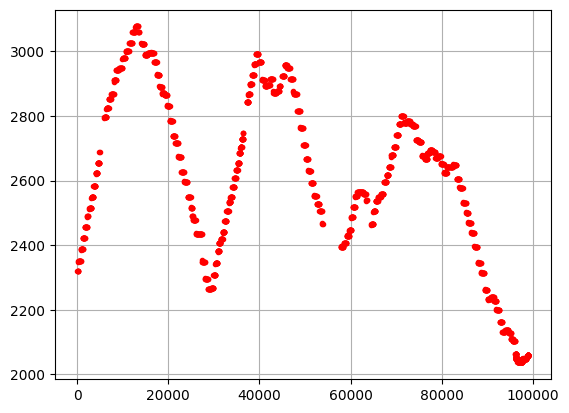

In [62]:
import matplotlib.pyplot as plt

datos = load_flujo_files("datasets/flujo_15_8_2017.csv")
datos = process_data(datos["LATITUD"],datos["LONGITUD"],datos["ALTITUD"],datos["DATETIME"],"17 S",\
                     datos["VELOCIDAD"],datos["CONSUMO_TOTAL"],datos["CPNSUMO_INSTANTANEO"])
datos = add_speeds(datos)
datos_l = datos.reset_index(drop=True)
plt.plot(datos_l["sum_distance"],datos_l["height"],"r.")
plt.grid()
plt.show()

Clustering Inicial para hallar errores

Min gap distance 33.400000000000205


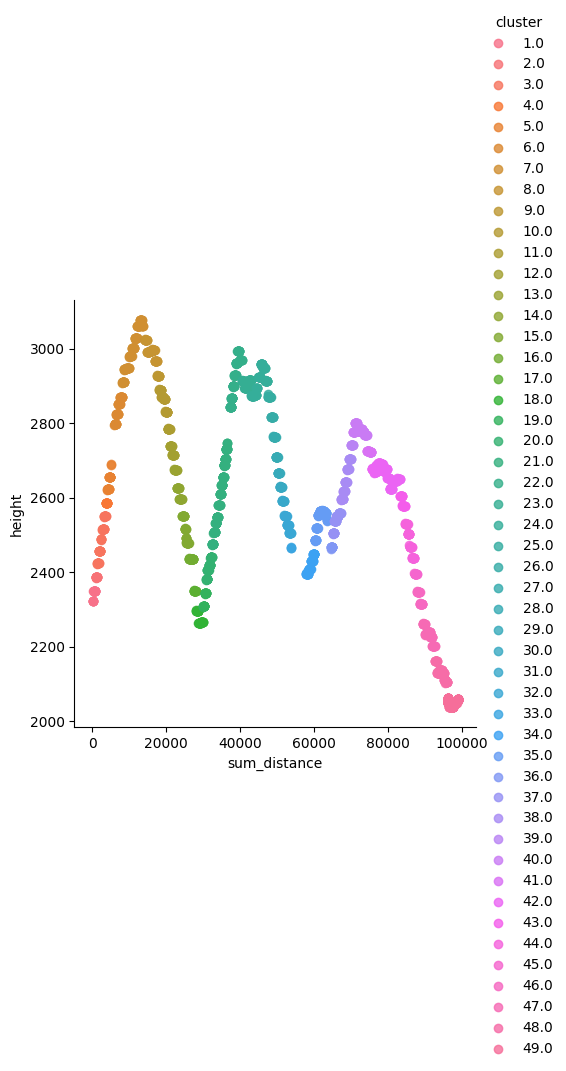

In [63]:
import seaborn as sns

data_clustered = tol_adjust(datos_l, 1.9)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)

Corrección de alturas

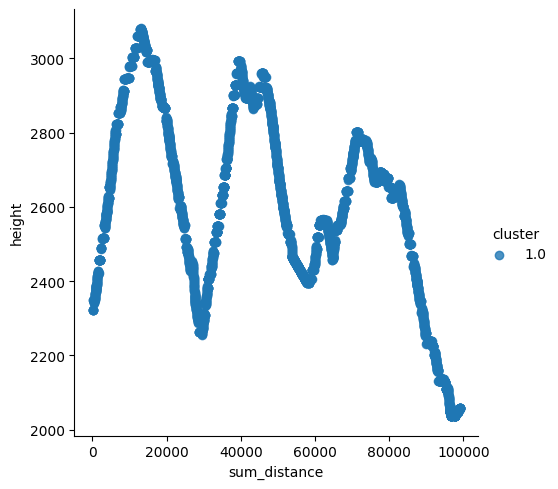

In [64]:
data_smooth = height_correction(data_clustered,10,17)
data_clustered = sdd_clust(data_smooth, 33.4) #use min gap distance in previous step
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.reset_index(drop=True)

Producir archivo final corregido

In [65]:
data_clustered = data_clustered[["date", "height","utm_x","utm_y","distance","slope","sum_distance","velocidad","timestamp","ds","velocidad_gps","consumo_total","consumo_inst"]]

xs = np.array(data_clustered["utm_x"])
ys = np.array(data_clustered["utm_y"])
utms = utm.to_latlon(xs,ys,17,northern=False) #14Q for Mexico, 17S for Ecuador
data_clustered["latitud"] = utms[0]
data_clustered["longitud"] = utms[1]
datosfinales = process_data(data_clustered["latitud"],data_clustered["longitud"],data_clustered["height"],data_clustered["date"],"17 S",\
                     data_clustered["velocidad_gps"],data_clustered["consumo_total"],data_clustered["consumo_inst"])
datosfinales = add_speeds(datosfinales)
datosfinales = datosfinales.reset_index(drop=True)
datosfinales.to_csv("datos_corregidos.csv", index=False)


Average height difference: 1.4774965254436374
